In [1]:
import math, os, sys, re
import pandas as pd
import numpy as np
import collections, itertools

# stats
from scipy.stats import gaussian_kde, poisson

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.colors import LogNorm
import seaborn as sns
plt.rcParams['figure.dpi'] = 300

import matplotlib.font_manager
font_dir = '/n/groups/marks/projects/CEPI/notebooks/ralph/myfonts/'
for font in matplotlib.font_manager.findSystemFonts(font_dir):
    matplotlib.font_manager.fontManager.addfont(font)
plt.rcParams['font.family'] = 'Helvetica'


In [2]:
def get_disease_clinvar_variants(
    variants,
    cond_pattern, 
    review_status,
    clin_sig,
    var_type,
    coding_only = False,
    short_only=True,
    mitochondrial=False
):
    print(cond_pattern)
    # select relevant rows
    phenotypes = variants['PhenotypeList'].str.lower()
    df = variants[(phenotypes.str.contains(cond_pattern)) & 
                  (variants['ReviewStatus'].isin(review_status)) & 
                  (variants['ClinicalSignificance'].isin(clin_sig)) & 
                  (variants['Type'].isin(var_type)) & 
                  (variants['PositionVCF'] > 0)]
    
    # select only coding variants
    if coding_only:
        df = df[df.Name.str.contains('\(p.')]
        
    # remove long variants
    if short_only:
        ref_lengths = df['Ref'].apply(len)
        alt_lengths = df['Alt'].apply(len)
        df = df[(alt_lengths <= 50) & (ref_lengths <= 50)]
    
    if not mitochondrial:
        df = df[df['Chromosome']!='MT']
    
    # consolidate clinical significances
    df['ClinicalSignificance'] = df['ClinicalSignificance'].replace({
        'Pathogenic/Likely pathogenic': 'Pathogenic',
        'Benign/Likely benign': 'Benign'
    })
    
    # consolidate review statuses
    df['ClinicalConfidence'] = df['ReviewStatus'].replace({
        'criteria provided, multiple submitters, no conflicts': 'high', 
        'reviewed by expert panel': 'high', 
        'practice guideline': 'high',
        'criteria provided, conflicting interpretations': 'conflicting',
        'criteria provided, single submitter': 'moderate'
    })
    return df

In [3]:
review_status = [
    'criteria provided, multiple submitters, no conflicts', 
    'reviewed by expert panel', 
    'practice guideline',
    'criteria provided, conflicting interpretations',
    'criteria provided, single submitter'
]

clin_sig = [
    'Uncertain significance',
    'Pathogenic',
    'Benign',
    'Likely pathogenic',
    'Pathogenic/Likely pathogenic',
    'Likely benign',
    'Conflicting interpretations of pathogenicity',
    'Benign/Likely benign'
]
var_type = [
    'single nucleotide variant',
    'Deletion',
    'Indel',
    'Insertion',
]

disease = {
    'hcm': 'hypertrophic cardiomyopathy',
    'als': 'amyotrophic lateral sclerosis',
    'dcm': 'dilated cardiomyopathy',
    'arvc': 'arrhythmogenic right ventricular cardiomyopathy',
    'brugada': 'brugada',
    'lqts': 'long qt syndrome',
    'parkinson': 'parkinson disease',
    'mnd': 'motor neuron disease',
    'hc': 'hypercholesterolemia'
}

disease_display = {
    'hcm': 'Hypertrophic cardiomyopathy (HCM)',
    'als': 'Amyotrophic lateral sclerosis (ALS)',
    'dcm': 'Dilated cardiomyopathy (DCM)',
    'arvc': 'Arrhythmogenic right ventricular cardiomyopathy (ARVC)',
    'brugada': 'Brugada syndrome',
    'lqts': 'Long qt syndrome (LQTS)',
    'parkinson': 'Parkinson disease',
    'mnd': 'Motor neuron disease (MND)',
    'hc': 'Hypercholesterolemia'
}

disease_abbr_display = {
    'hcm': 'HCM',
    'als': 'ALS',
    'dcm': 'DCM',
    'arvc': 'ARVC',
    'brugada': 'Brugada',
    'lqts': 'LQTS',
    'parkinson': "Parkinson's",
    'mnd': 'MND',
    'hc': 'Hyperchol.'
}

In [5]:
variants = pd.read_parquet("data/clinvar/variant_summary_GRCh38.parquet")

In [6]:
clinvar_tables = {
    k: get_disease_clinvar_variants(variants, v, review_status, clin_sig, var_type, coding_only=False, short_only=True) 
    for k,v in disease.items()
}

hypertrophic cardiomyopathy
amyotrophic lateral sclerosis
dilated cardiomyopathy
arrhythmogenic right ventricular cardiomyopathy
brugada
long qt syndrome
parkinson disease
motor neuron disease
hypercholesterolemia


In [5]:
disease_table_paths = {}
for dis, df in clinvar_tables.items():
    path = f"/n/groups/marks/users/ralph/popgen/data/clinvar_disease_tables/{dis}.variants.csv"
    df.to_csv(path, index=False)
    disease_table_paths[dis] = path

pd.DataFrame.from_dict(disease_table_paths, orient='index').to_csv('disease_table_paths.csv', header=False)

#### All high confidence variants:

In [28]:
df = get_disease_clinvar_variants(variants, "", review_status, clin_sig, var_type, coding_only=False, short_only=True) 

In [30]:
df = df[df.ClinicalConfidence=='high']

In [35]:
path = f"/n/groups/marks/users/ralph/popgen/data/clinvar_disease_tables/high.confidence.variants.csv"
df.to_csv(path, index=False)
pd.DataFrame.from_dict({'alldis.highconf': path}, orient='index').to_csv('all_disease_table_paths.csv', header=False)

### Picking gnomAD genomes columns

In [79]:
tags = []
with open('gnomad.genomes.header', 'r') as header:
    for line in header.readlines():
        match = re.search("##INFO=<ID=(.*?),", line)
        if match:
            tags.append(match.group(1))
tags_string = ('\n'.join(tags))
fields = []
fields += re.findall("((?:AC|AN)(?:-controls_and_biobanks)?(?:-...)?)\n", tags_string)
fields += re.findall("(?<=\n)((?:|AN_|AC_)?popmax)\n", tags_string)
fields += re.findall("(faf9[95](?:_popmax)?(?:-...)?)\n", tags_string)

with open('gnomad.genomes.fields', 'w') as file:
    file.writelines('\n'.join(list(set(fields))))

### Picking gnomAD exomes columns

In [47]:
tags = []
with open('gnomad.exomes.header', 'r') as header:
    for line in header.readlines():
        match = re.search("##INFO=<ID=(.*?),", line)
        if match:
            tags.append(match.group(1))
tags_string = (',,'.join(tags))
fields = []
fields += re.findall("(?:^|,)((?:controls_)?(?:AC|AN)(?:_...)?(?:_...)?),", tags_string)
fields += re.findall("(?:^|,)(faf9[59].*?),", tags_string)
fields += re.findall(",((?:controls_)?(?:AC_|AN_)?popmax),", tags_string)

with open('gnomad.exomes.fields', 'w') as file:
    file.writelines('\n'.join(list(set(fields))))

### Summarizing ClinVar variants

In [7]:
for dis, df in clinvar_tables.items():
    df['disease'] = dis
clinvar_full = pd.concat(clinvar_tables.values()).drop_duplicates(subset=['Chromosome', 'PositionVCF', 'Ref', 'Alt'])


In [8]:
clinvar_full

,AlleleID,Type,Name,GeneID,GeneSymbol,HGNC_ID,ClinicalSignificance,ClinSigSimple,LastEvaluated,RS# (dbSNP),...,Guidelines,TestedInGTR,OtherIDs,SubmitterCategories,VariationID,PositionVCF,Ref,Alt,ClinicalConfidence,disease
630,15365,single nucleotide variant,NM_144573.4(NEXN):c.1955A>G (p.Tyr652Cys),91624,NEXN,HGNC:29557,Conflicting interpretations of pathogenicity,1,2022-10-24,137853197,...,NaN,0,"ClinGen:CA142143,UniProtKB:Q0ZGT2#VAR_063011,O...",3,326,77942756,A,G,conflicting,hcm
824,15470,single nucleotide variant,NM_020312.4(COQ9):c.730C>T (p.Arg244Ter),57017,COQ9,HGNC:25302,Pathogenic,1,2020-05-13,267606751,...,NaN,0,"ClinGen:CA114275,OMIM:612837.0001",3,431,57459583,C,T,high,hcm
1389,15773,single nucleotide variant,NM_024334.3(TMEM43):c.1073C>T (p.Ser358Leu),79188,TMEM43,HGNC:28472,Pathogenic,1,2022-09-13,63750743,...,"ACMG2013,ACMG2016,ACMG2021,ACMG2022",1,"ClinGen:CA024568,UniProtKB:Q9BTV4#VAR_044438,O...",3,734,14141665,C,T,high,hcm
1493,15827,single nucleotide variant,NM_015141.4(GPD1L):c.370A>G (p.Ile124Val),23171,GPD1L,HGNC:28956,Conflicting interpretations of pathogenicity,1,2022-10-20,72552293,...,NaN,0,"ClinGen:CA213881,UniProtKB:Q8N335#VAR_044045,O...",3,788,32140231,A,G,conflicting,hcm
7762,19282,single nucleotide variant,NM_033118.4(MYLK2):c.260C>T (p.Ala87Val),85366,MYLK2,HGNC:16243,Conflicting interpretations of pathogenicity,1,2022-10-28,121908107,...,NaN,0,"ClinGen:CA116734,UniProtKB:Q9H1R3#VAR_014197,O...",3,4243,31820333,C,T,conflicting,hcm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3897998,2189870,single nucleotide variant,NM_000527.5(LDLR):c.2046C>T (p.Leu682_Pro683=),3949,LDLR,HGNC:6547,Likely benign,0,2022-06-11,-1,...,"ACMG2013,ACMG2016,ACMG2021,ACMG2022",0,None,2,2131882,11120428,C,T,moderate,hc
3898960,2190350,single nucleotide variant,NM_000384.3(APOB):c.6678C>T (p.Ile2226_His2227=),338,APOB,HGNC:603,Likely benign,0,2022-05-07,-1,...,"ACMG2013,ACMG2016,ACMG2021,ACMG2022",0,None,2,2134942,21010190,G,A,moderate,hc
3900246,2190993,single nucleotide variant,NM_174936.4(PCSK9):c.1560C>A (p.Val520_Tyr521=),255738,PCSK9,HGNC:20001,Likely benign,0,2022-04-23,-1,...,"ACMG2013,ACMG2016,ACMG2021,ACMG2022",0,None,2,2129569,55059542,C,A,moderate,hc
3900900,2191320,Insertion,NM_000527.5(LDLR):c.1067_1068insAGAGTGTCAGGATC...,3949,LDLR,HGNC:6547,Uncertain significance,0,2022-04-28,-1,...,"ACMG2013,ACMG2016,ACMG2021,ACMG2022",0,None,2,2131185,11111517,T,TCGAAGAGTGTCAGGATCC,moderate,hc


In [9]:
clinvar_coding = clinvar_full[clinvar_full.Name.str.contains('\(p.')]
clinvar_noncoding = clinvar_full[~clinvar_full.Name.str.contains('\(p.')]

In [10]:
mpl.rcParams['hatch.linewidth'] = 0.5

/tmp/ipykernel_13458/2517648684.py:45: PerformanceWarning: indexing past lexsort depth may impact performance.
  coding_df = counts_coding[(conf, clin)]
/tmp/ipykernel_13458/2517648684.py:46: PerformanceWarning: indexing past lexsort depth may impact performance.
  noncoding_df = counts_noncoding[(conf, clin)]


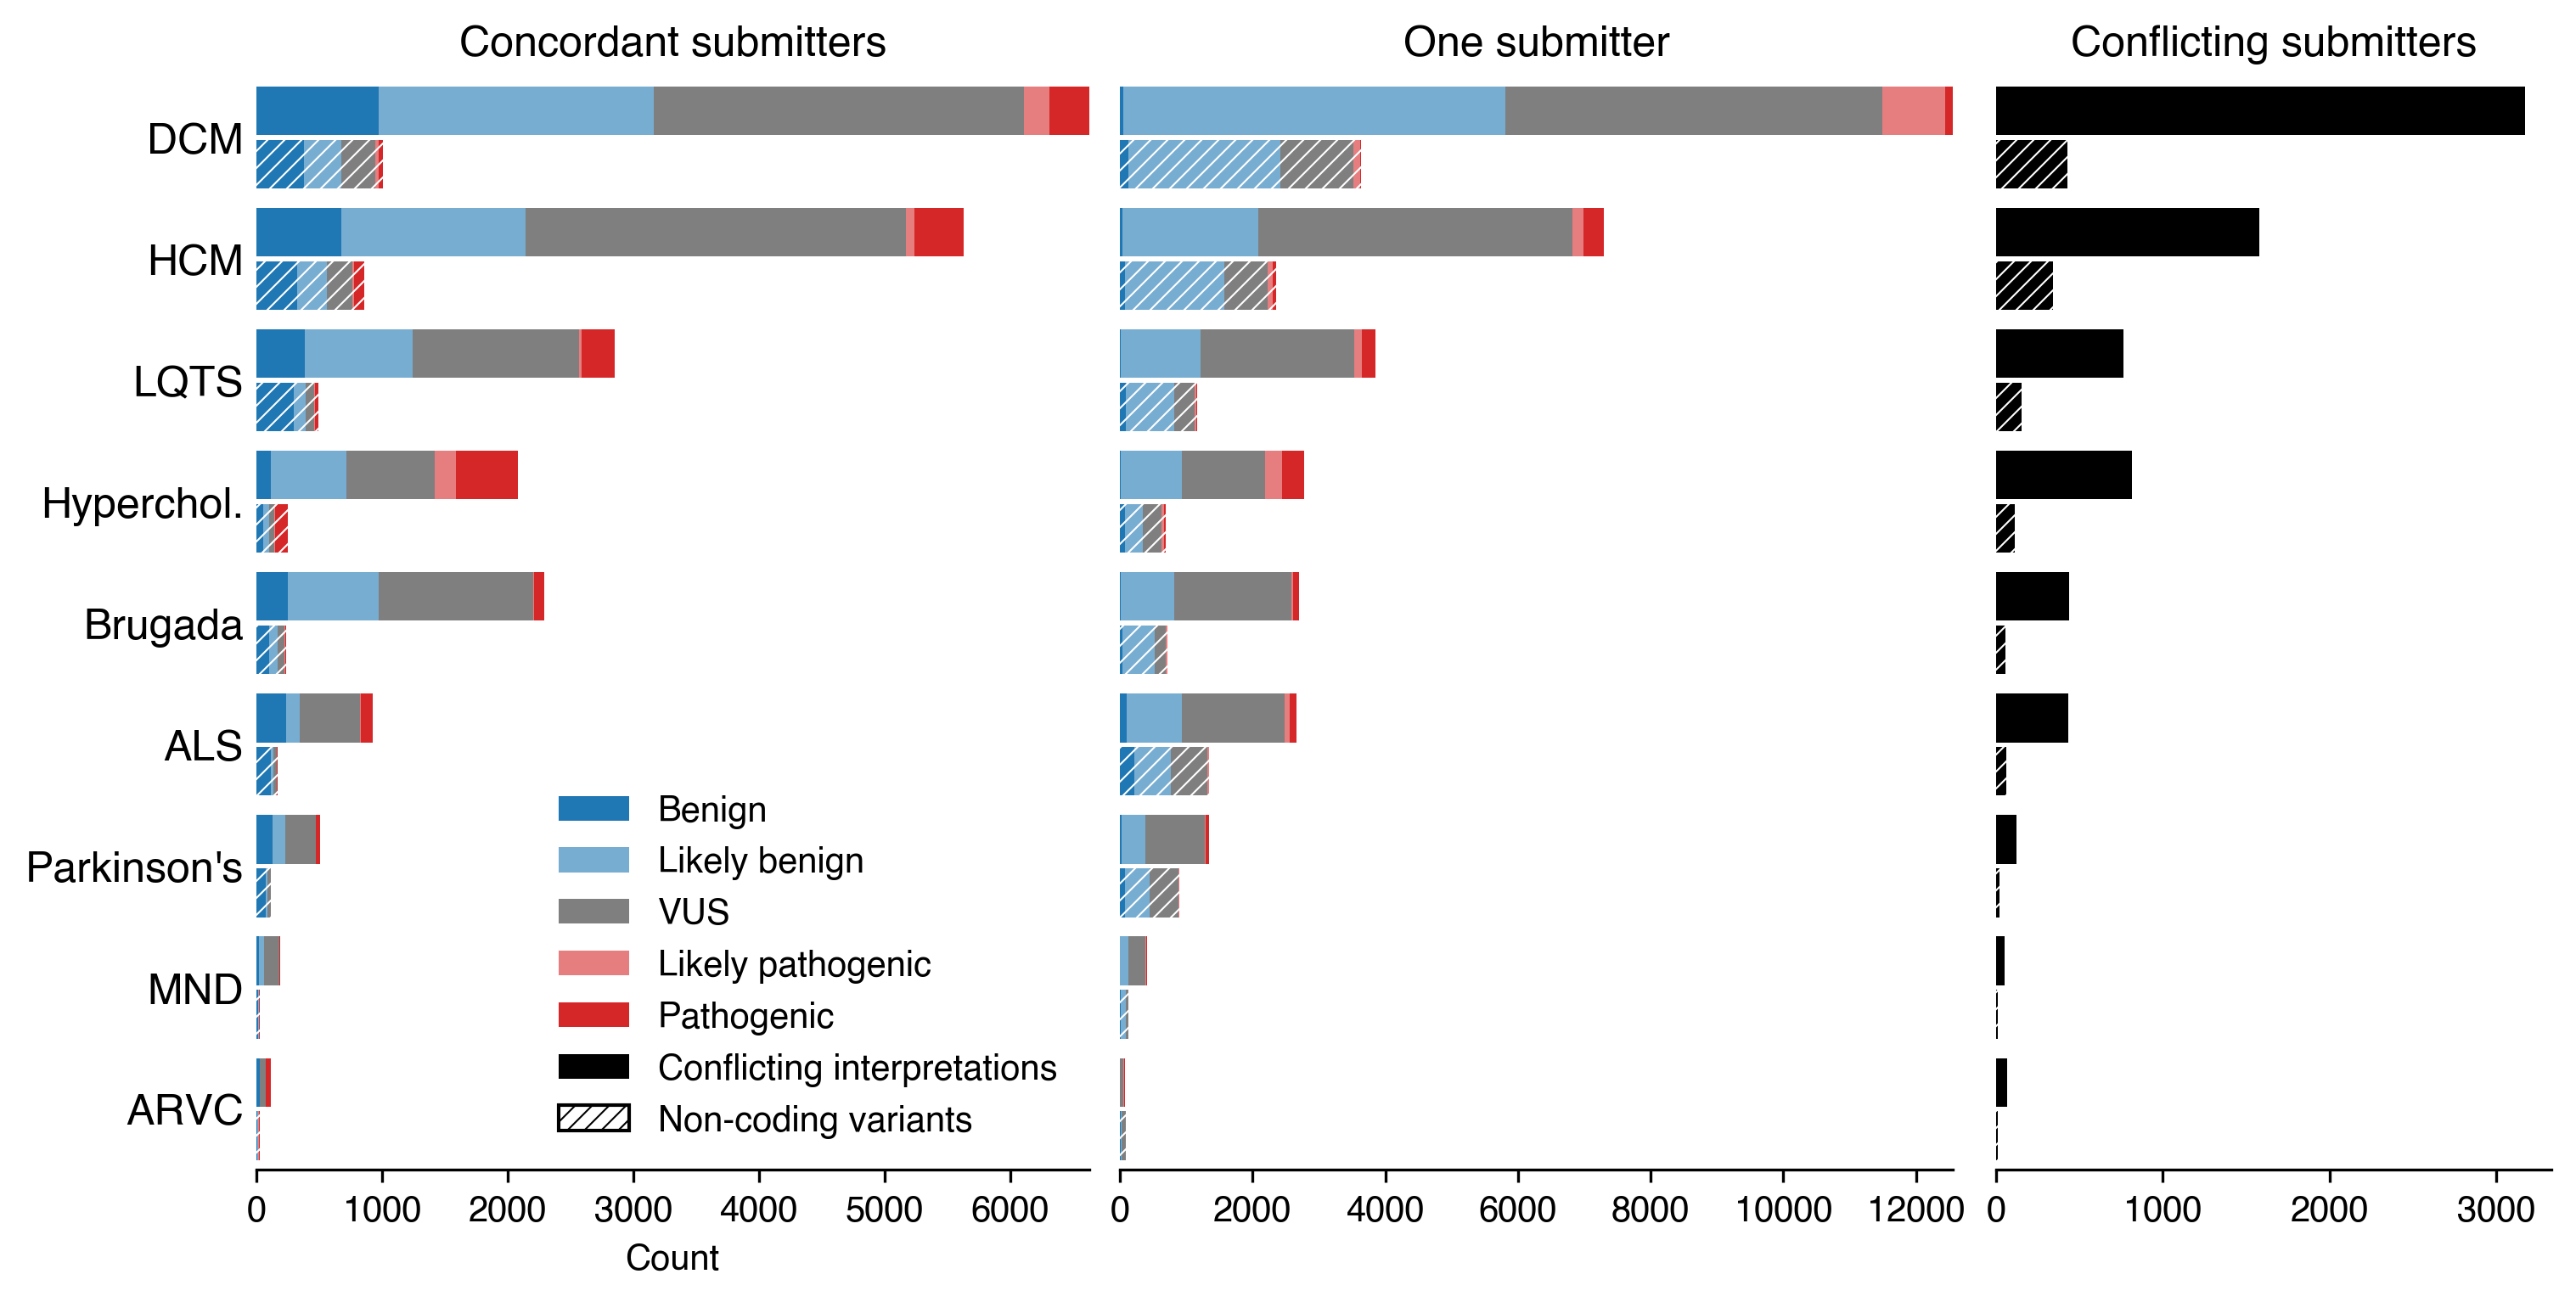

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5), constrained_layout=True, sharey=True, gridspec_kw={'width_ratios':[3,3,2]})

ys = np.arange(len(disease))
coding_ys = ys + 0.22
noncoding_ys = ys - 0.22

conf_labels = {
    'high': 'Concordant submitters', 
    'moderate': 'One submitter', 
    'conflicting': 'Conflicting submitters'
}
clin_labels = {
    'Benign': {'color': 'tab:blue', 'alpha': 1, 'display': 'Benign'},
    'Likely benign': {'color': 'tab:blue', 'alpha': 0.6, 'display': 'Likely benign'},
    'Uncertain significance': {'color': 'tab:grey', 'alpha': 1, 'display': 'VUS'},
    'Likely pathogenic': {'color': 'tab:red', 'alpha': 0.6, 'display': 'Likely pathogenic'},
    'Pathogenic': {'color': 'tab:red', 'alpha': 1, 'display': 'Pathogenic'},
    'Conflicting interpretations of pathogenicity': {'color': 'k', 'alpha': 1, 'display': 'Conflicting interpretations'},
}

counts_coding = (clinvar_coding[['disease', 'ClinicalConfidence', 'ClinicalSignificance']]
          .astype({'disease':'category'})
          .groupby(['ClinicalConfidence', 'ClinicalSignificance', 'disease' ])
          .agg(len))
counts_noncoding = (clinvar_noncoding[['disease', 'ClinicalConfidence', 'ClinicalSignificance']]
          .astype({'disease':'category'})
          .groupby(['ClinicalConfidence', 'ClinicalSignificance', 'disease' ])
          .agg(len))

disease_order = clinvar_full['disease'].value_counts().index.tolist()

levels = [conf_labels.keys(), clin_labels.keys(), disease_order]
new_index = pd.MultiIndex.from_product(levels, names=counts.index.names)
counts_coding = counts_coding.reindex(new_index, fill_value=0)
counts_noncoding = counts_noncoding.reindex(new_index, fill_value=0)

for ax, (conf, conf_disp) in zip(axs, conf_labels.items()):
    ax.set_title(conf_disp)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='y', which='both', length=0)
    coding_left, noncoding_left = np.zeros(len(disease_order)), np.zeros(len(disease_order))
    for clin, fmt in clin_labels.items():
        coding_df = counts_coding[(conf, clin)]
        noncoding_df = counts_noncoding[(conf, clin)]
        ax.barh(coding_ys[::-1], height=0.4, width=coding_df.values, left=coding_left, color=fmt['color'], alpha=fmt['alpha'])
        ax.barh(noncoding_ys[::-1], height=0.4, width=noncoding_df.values, left=noncoding_left, color=fmt['color'], alpha=fmt['alpha'])
        coding_left += coding_df.values
        noncoding_left += noncoding_df.values
    
    ax.barh(noncoding_ys[::-1], height=0.4, width=noncoding_left, left=0, facecolor="none", alpha=fmt['alpha'], hatch='/////', edgecolor='white', lw=0)
axs[0].set_xlabel('Count')
axs[0].set_ylim(ys.min()-0.5, ys.max()+0.5)
axs[0].set_yticks(ys)
axs[0].set_yticklabels([disease_abbr_display[d] for d in disease_order[::-1]], fontsize=12)

patches_handles = [
    Patch(facecolor=v['color'], edgecolor=None, alpha=v['alpha'], label=v['display']) for v in clin_labels.values()
] + [Patch(facecolor='w', edgecolor='k', hatch='/////', label="Non-coding variants")]
axs[0].legend(handles=patches_handles, frameon=False, fontsize=10);
fig.savefig('clinvar_summary.png')

/tmp/ipykernel_13458/3484220982.py:37: PerformanceWarning: indexing past lexsort depth may impact performance.
  df = counts[(conf, clin)]


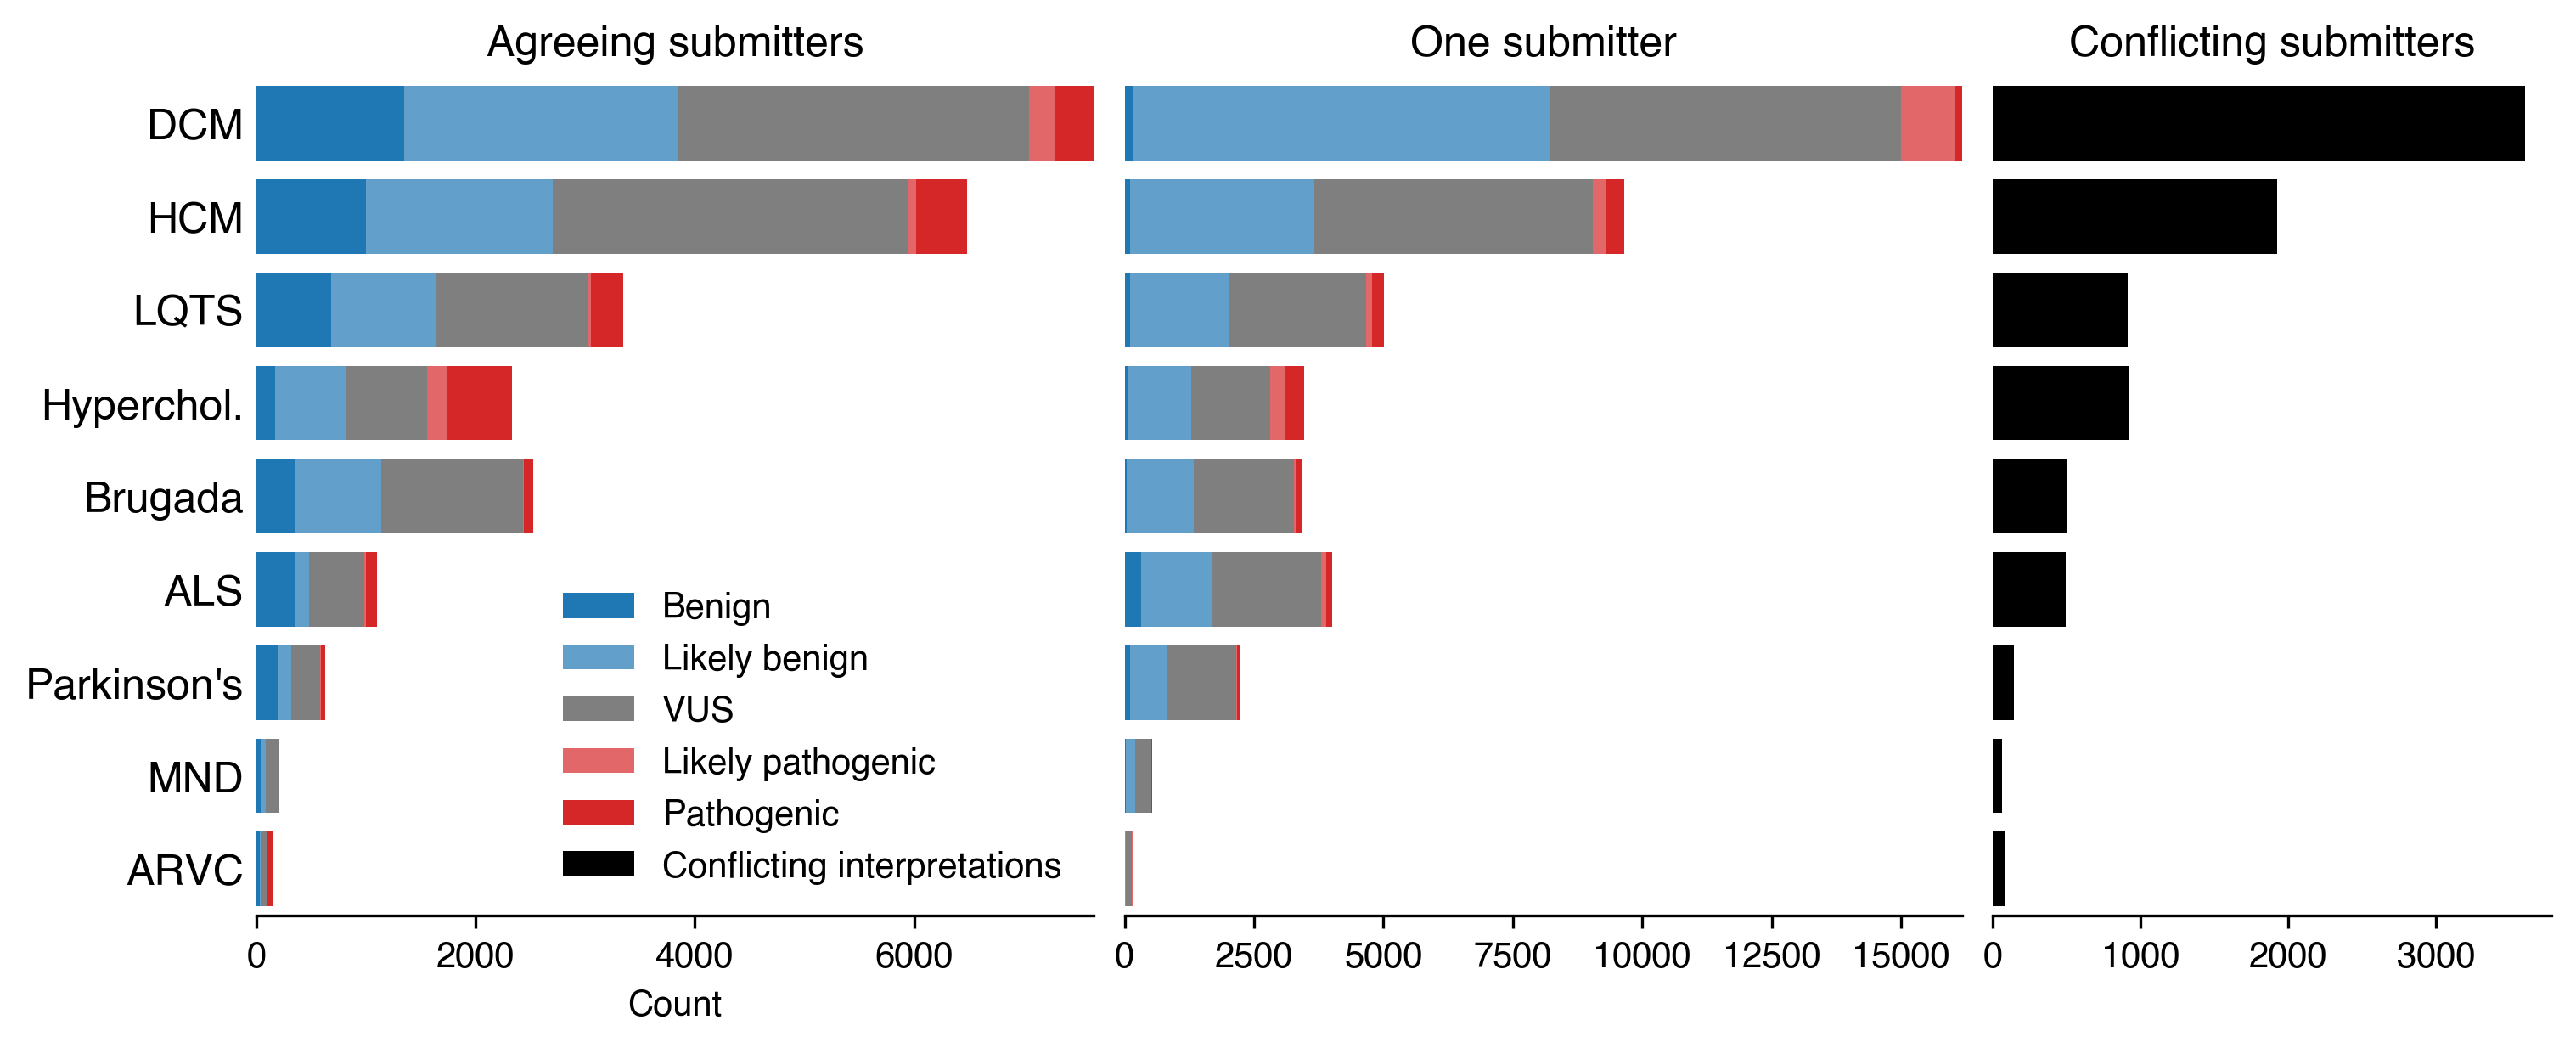

In [12]:
fig, axs = plt.subplots(1,3,figsize=(10, 4), constrained_layout=True, sharey=True, gridspec_kw={'width_ratios':[3,3,2]})

ys = np.arange(len(disease))

conf_labels = {
    'high': 'Agreeing submitters', 
    'moderate': 'One submitter', 
    'conflicting': 'Conflicting submitters'
}
clin_labels = {
    'Benign': {'color': 'tab:blue', 'alpha': 1, 'display': 'Benign'},
    'Likely benign': {'color': 'tab:blue', 'alpha': 0.7, 'display': 'Likely benign'},
    'Uncertain significance': {'color': 'tab:grey', 'alpha': 1, 'display': 'VUS'},
    'Likely pathogenic': {'color': 'tab:red', 'alpha': 0.7, 'display': 'Likely pathogenic'},
    'Pathogenic': {'color': 'tab:red', 'alpha': 1, 'display': 'Pathogenic'},
    'Conflicting interpretations of pathogenicity': {'color': 'k', 'alpha': 1, 'display': 'Conflicting interpretations'},
}

counts = (clinvar_full[['disease', 'ClinicalConfidence', 'ClinicalSignificance']]
          .astype({'disease':'category'})
          .groupby(['ClinicalConfidence', 'ClinicalSignificance', 'disease' ])
          .agg(len))
disease_order = clinvar_full['disease'].value_counts().index.tolist()

levels = [conf_labels.keys(), clin_labels.keys(), disease_order]
new_index = pd.MultiIndex.from_product(levels, names=counts.index.names)
counts = counts.reindex(new_index, fill_value=0)

for ax, (conf, conf_disp) in zip(axs, conf_labels.items()):
    ax.set_title(conf_disp)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='y', which='both', length=0)
    left = np.zeros(len(disease_order))
    for clin, fmt in clin_labels.items():
        df = counts[(conf, clin)]
        ax.barh(ys[::-1], width=df.values, left=left, color=fmt['color'], alpha=fmt['alpha'])
        left += df.values
axs[0].set_xlabel('Count')
axs[0].set_ylim(ys.min()-0.5, ys.max()+0.5)
axs[0].set_yticks(ys)
axs[0].set_yticklabels([disease_abbr_display[d] for d in disease_order[::-1]], fontsize=12)
axs[0].legend([clin_labels[k]['display'] for k in clin_labels.keys()], frameon=False, fontsize=10);

### AF analysis

#### TODO
- Make a list of INFO tags for the exomes data

In [11]:
genome_afs = pd.read_table('data/gnomad/gnomad.genomes.annotations.tab', low_memory=False)

In [21]:
df = clinvar_tables['hcm'].copy()

In [22]:
df = df[df['PositionVCF']>0]

In [23]:
df['ID'] = df['Chromosome'].astype(str)+'-'+df['PositionVCF'].astype(str)+'-'+df['Ref'].str[:5].astype(str)+'-'+df['Alt'].str[:5].astype(str)

In [28]:
genome_afs['ID'] = genome_afs['CHROM'].str[3:].astype(str) + '-' + genome_afs['POS'].astype(str) + '-' + genome_afs['REF'].str[:5].astype(str) + '-' + genome_afs['ALT'].str[:5].astype(str)

In [32]:
dfaf = df.merge(genome_afs, left_on='ID', right_on='ID', how='inner')

In [50]:
dfaf['ClinicalSignificance']

0       Conflicting interpretations of pathogenicity
1                                         Pathogenic
2       Conflicting interpretations of pathogenicity
3       Conflicting interpretations of pathogenicity
4                                             Benign
                            ...                     
8583                                   Likely benign
8584                          Uncertain significance
8585                          Uncertain significance
8586                                   Likely benign
8587                          Uncertain significance
Name: ClinicalSignificance, Length: 8588, dtype: category
Categories (87, object): ['Affects', 'Affects; association', 'Affects; risk factor', 'Benign', ..., 'other', 'protective', 'protective; risk factor', 'risk factor']

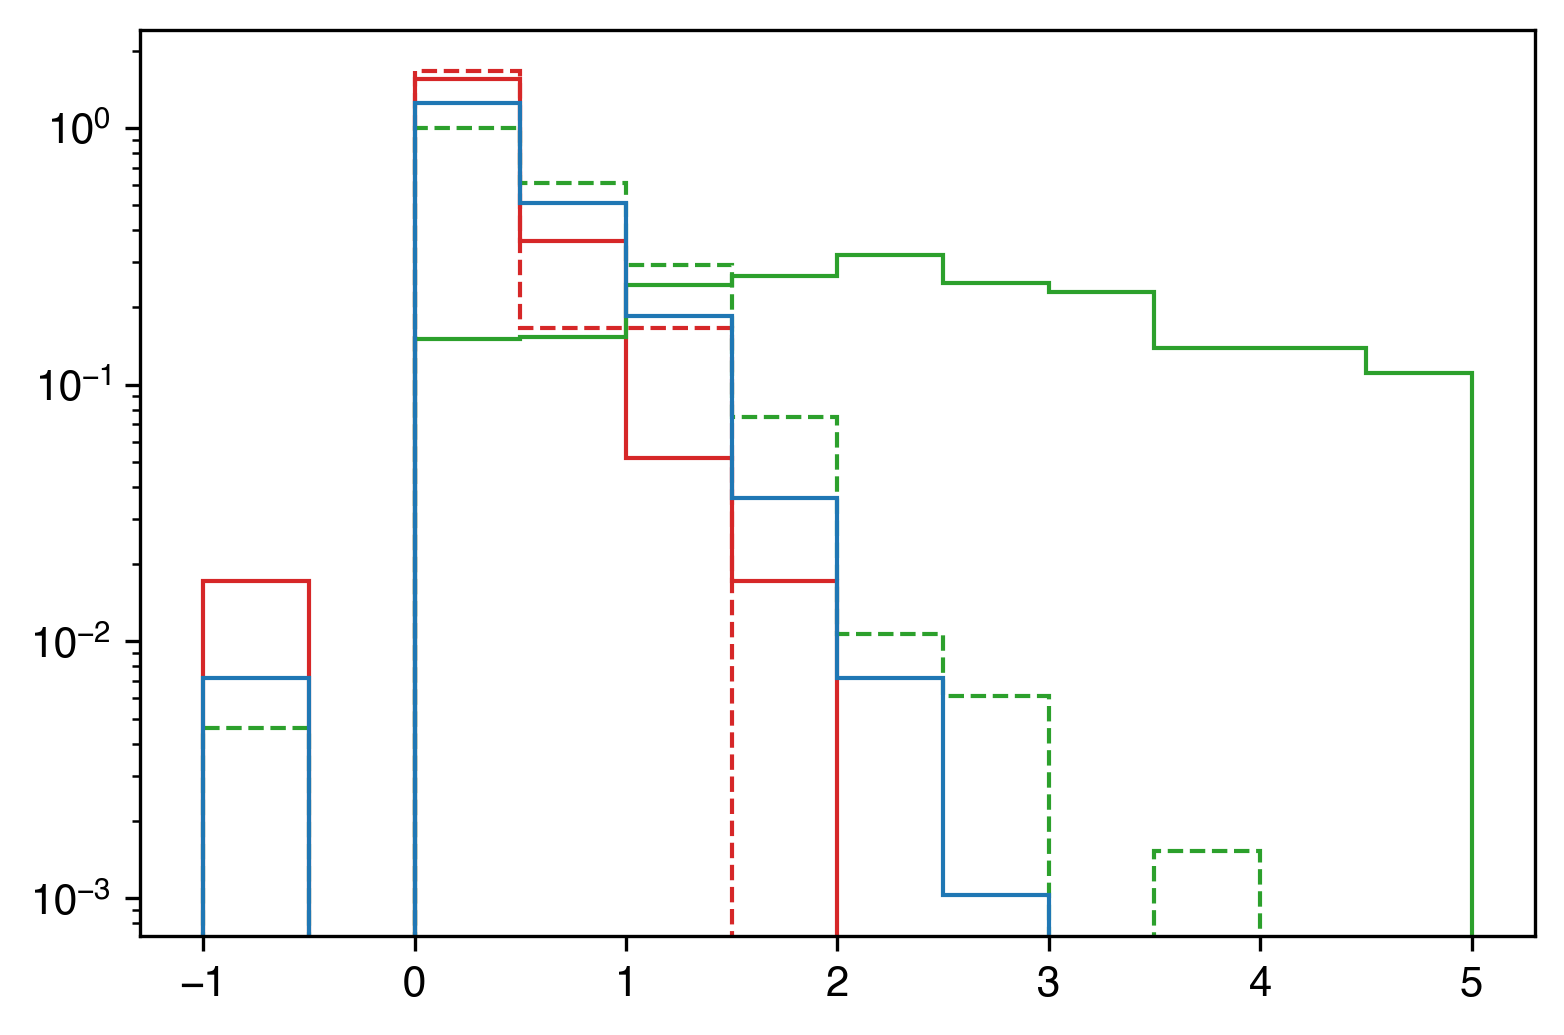

In [78]:
bins=np.arange(-1, 5.5, 0.5)
plt.hist(np.log10(dfaf[(dfaf['ClinicalSignificance'].isin(['Pathogenic'])) & 
                       (dfaf['ClinicalConfidence']=='high')]['AC']+1e-1), alpha=1,  density=True, bins=bins, color='tab:red', histtype='step')

plt.hist(np.log10(dfaf[(dfaf['ClinicalSignificance'].isin(['Likely pathogenic'])) & 
                       (dfaf['ClinicalConfidence']=='high')]['AC']+1e-1), alpha=1,  density=True, bins=bins, color='tab:red', histtype='step', ls='dashed')

plt.hist(np.log10(dfaf[(dfaf['ClinicalSignificance'].isin(['Benign']))& 
                       (dfaf['ClinicalConfidence']=='high')]['AC']+1e-1), alpha=1, density=True, bins=bins, color='tab:green', histtype='step')

plt.hist(np.log10(dfaf[(dfaf['ClinicalSignificance'].isin(['Likely benign']))& 
                       (dfaf['ClinicalConfidence']=='high')]['AC']+1e-1), alpha=1, density=True, bins=bins, color='tab:green', histtype='step', ls='dashed')

plt.hist(np.log10(dfaf[(dfaf['ClinicalSignificance']=='Uncertain significance')& 
                       (dfaf['ClinicalConfidence']=='high')& 
                       (dfaf['ClinicalConfidence']=='high')]['AC']+1e-1), alpha=1, density=True, bins=bins, color='tab:blue', histtype='step')

# plt.hist(np.log10(dfaf[(dfaf['ClinicalSignificance']=='Conflicting interpretations of pathogenicity')& 
#                        (dfaf['ClinicalConfidence']=='high')]['AC']+1e-1), alpha=1, density=True, bins=bins, color='tab:grey', histtype='step')
plt.yscale('log')

In [ ]:
df['var_id'] = df['Chromosome'].astype(str)+'-'+df['PositionVCF'].astype(str)+'-'+df['Ref'].astype(str)+'-'+df['Alt'].astype(str)

In [7]:
def compute_filtering_AF(AC, AN, max_iter=10):
    """Compute the filtering allele frequencies described in Whiffin et al. (2017)
    
    Whiffin et al. use R's uniroot function and increment by 1e-6 to find the maximum
    filtering AF with a 95% cumulative probability of observing at least as many as
    AC occurences of a variant in the data. 
    
    This implementation is much faster, much more scalable (fully vectorized), and more 
    exact (no arbitrary incrementation), as it uses the Newton-Raphson root-finding method 
    and an analytically derived derivative.
    
    Parameters:
    -----------
        AC: (int or NumPy array of int) The allele counts observed in a genotype dataset.
            Array input should be of dimensions (num_snps,).
        AN: (int or NumPy array of int, same as AN) The allele numbers in the same dataset
            in which the allele counts were observed. AN should have the same type and
            dimensions as AC.
        max_iter: (int) The maximum number of iterations done in the Newton-Raphson
            optimization.
            
    Note: AC and AN can also be floats as long as the floats are whole numbers.
    
    Returns:
    --------
        AF: (float or NumPy array of float) The filtering allele frequencies described in 
            Whiffin et al. (2017). Default is 10.
    
    """
    
    assert AN.shape == AC.shape, "AN and AC must have the same dimensions"
    
    # initialize AF
    AF_0 = AC/AN
    
    for i in range(max_iter):
        # compute f and its derivative
        f = poisson.cdf(AC, mu=AF_0*AN) - 0.95
        dfdAF = -AN * poisson.pmf(AC, mu=AF_0*AN)
        
        # Newton-Raphson step
        AF_1 = AF_0 - f/dfdAF
        
        # break if all converged
        if np.isclose(AF_1, AF_0, rtol=1e-14, atol=1e-14).all():
            break
        else:
            AF_0 = AF_1
    
    return AF_1

In [8]:
AN_eur = 10824 + 56885
AN_afr = 8128

In [42]:
AN_afr/AN_eur

0.12004312572922358

In [66]:
ANs_eur = np.power(10, np.arange(3, 7, 0.01)).astype(int)
ANs_afr = (ANs_eur * 0.12).astype(int)

In [69]:
ACs_eur = (ANs_eur * 0.01).astype(int)
ACs_afr = (ANs_afr * 0.05).astype(int)

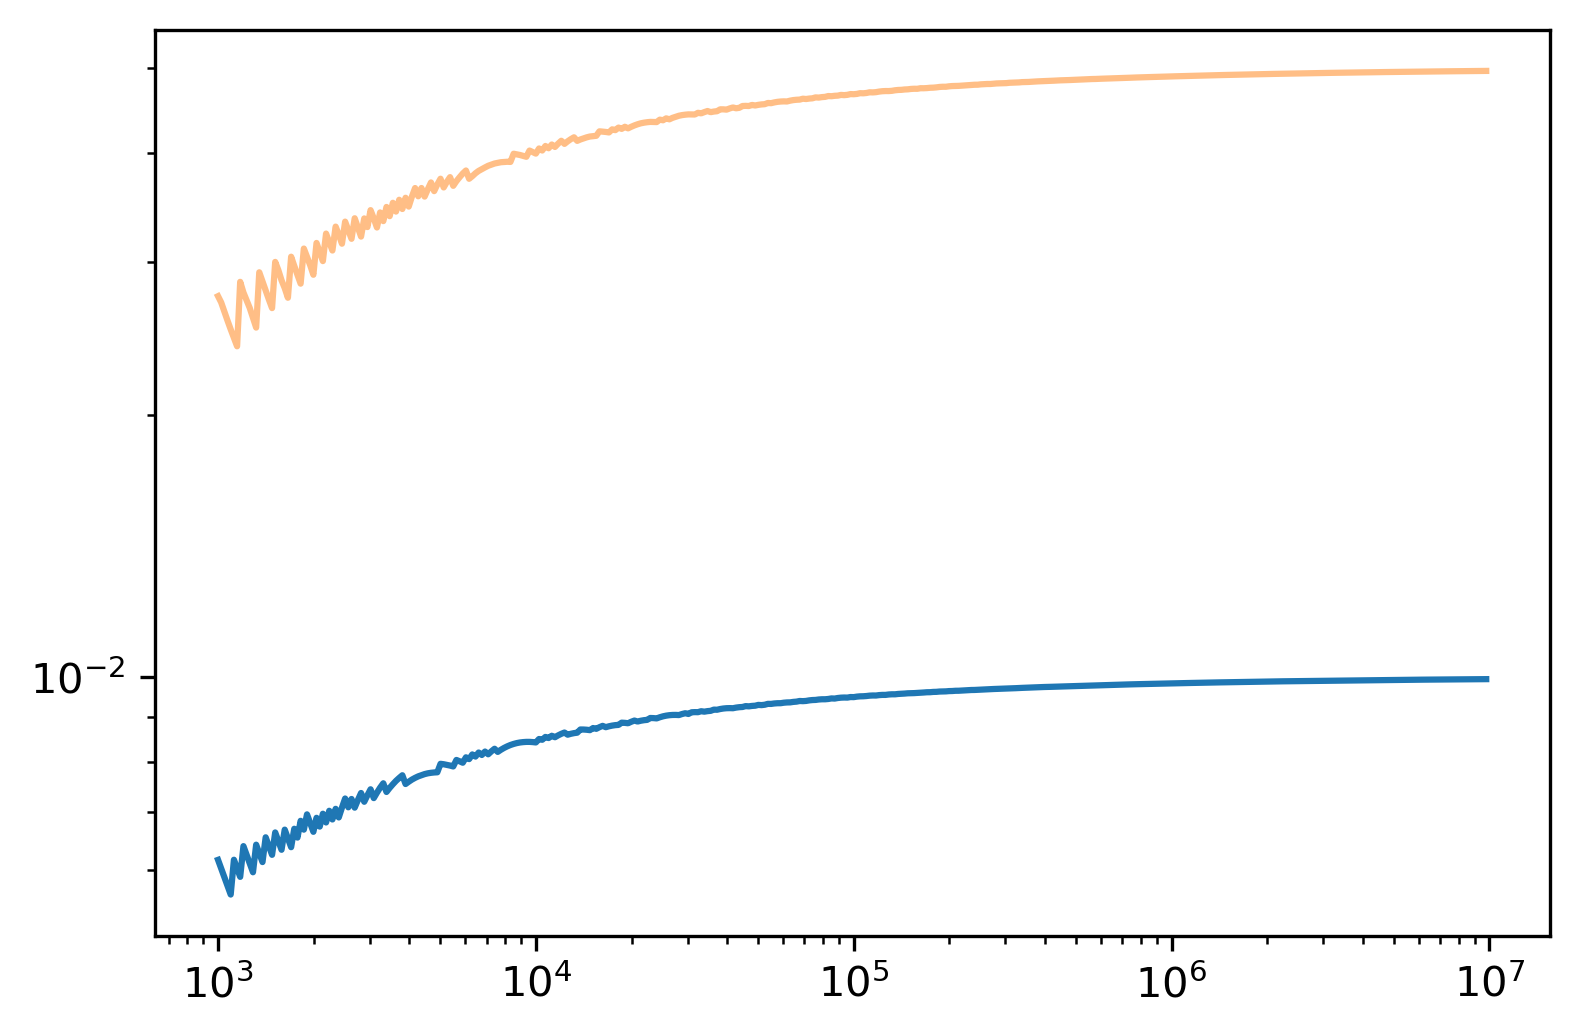

In [70]:
plt.plot(ANs_eur, compute_filtering_AF(ACs_eur, ANs_eur))
plt.plot(ANs_eur, compute_filtering_AF(ACs_afr, ANs_afr), alpha=0.5)
plt.yscale('log')
plt.xscale('log')

In [19]:
np.array([AN_eur * 0.01, AN_afr * 0.02]).astype(int)

array([677, 162])

In [18]:
compute_filtering_AF(np.array([AN_eur * 0.01, AN_afr * 0.02]).astype(int), np.array([AN_eur, AN_afr]))

array([0.0093894 , 0.01754227])

In [4]:
compute_filtering_AF(2, 100_000)

8.176914471639537e-06

In [30]:
AC, AN = 3, 100_000
AF = AC/AN

In [41]:
AFs = np.arange(0, AF, 1e-10)

In [107]:
def f(AF, AC, AN):
    return poisson.cdf(AC, mu=AF*AN) - 0.95
def dfdAF(AF, AC, AN):
    return -AN * poisson.pmf(AC, mu=AF*AN)

In [102]:
f(2/100_000, 2, 100_000)

-0.27332358381693656

In [97]:
dfdAF(2/100_000, 2, 100_000)

-0.2706705664732254

In [106]:
poisson.pmf(2, mu=2)*1e5

27067.05664732254

0.002
0.0018470778584982884
0.0017988614632392273
0.001784051074617556
0.0017826360042227693
0.0017826237152676141
0.0017826237143467889
0.0017826237143467882
0.0017826237143467884
0.0017826237143467884


0.0017826237143467884

In [67]:
AC = np.random.randint(2, 20, size=20)

In [68]:
AN = np.random.randint(1000, 10000, size=20)

In [69]:
AF_0 = AC/AN

In [72]:
AC, AN

(array([ 8,  8, 18, 16, 10,  8, 11,  7,  6,  2,  5, 16, 17,  2, 19,  6,  6,
        18, 16,  5]),
 array([8485, 4147, 8087, 1000, 4032, 1729, 4894, 3993, 3884, 7896, 2630,
        9977, 7429, 1584, 3177, 3214, 8028, 7658, 7243, 4544]))

In [71]:
f(AF_0, AC, AN)

array([-0.35745266, -0.35745266, -0.38775501, -0.38403758, -0.36696025,
       -0.35745266, -0.37073324, -0.35128616, -0.34369722, -0.27332358,
       -0.33403935, -0.38403758, -0.38597709, -0.27332358, -0.38939261,
       -0.34369722, -0.34369722, -0.38775501, -0.38403758, -0.33403935])

In [59]:
f(8.1768e-6, 3, 100_000)

0.04022566227592694

In [98]:
AC = 2
AN = 100_000
AFs = np.arange(0, AC/AN+1e-7, 1e-7)

In [100]:
y = poisson.cdf(2, AFs*AN)

In [101]:
(y[-1] - y[-2])/1e-7

-27066.831652410307

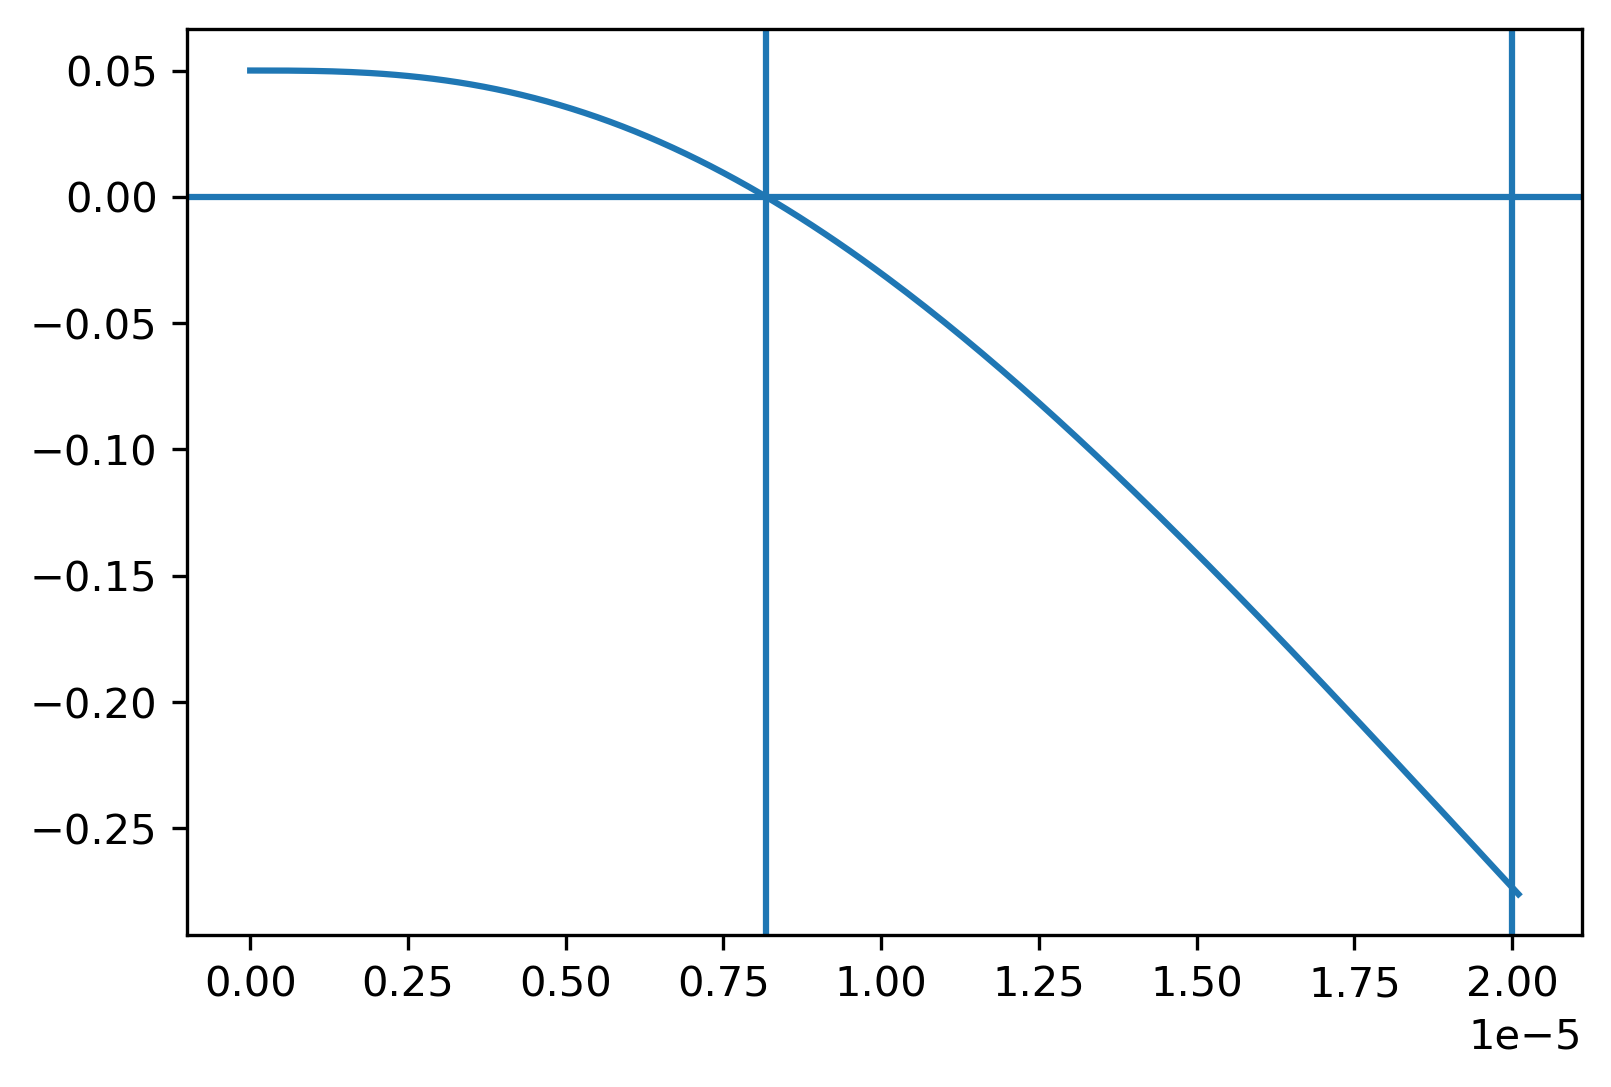

In [104]:
plt.plot(AFs, poisson.cdf(2, AFs*AN)-0.95)
plt.axhline(0)
plt.axvline(2/AN)
plt.axvline(8.17e-6)

In [29]:
poisson.ppf(0.95, 8.17e-6*AN)

1.0

In [ ]:
def compute_filtering_af(AC, AN):
    